In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras import backend as K
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/dataset/train'
validation_data_dir = '/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/dataset/test'
epochs = 100
batch_size = 32


In [0]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


In [6]:
vgg16 = VGG16(weights='imagenet')

x  = vgg16.get_layer('fc2').output
prediction = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)


# base_model = VGG16(weights='imagenet',include_top= False, input_shape=input_shape)

# x = base_model.output
# x = Flatten(name='flatten')(x)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# prediction = Dense(2, activation='linear', name='predictions')(x)
# # prediction = Dense(output_dim=1, activation='sigmoid', name='logit')(x)

# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# predictions = Dense(2, activation='linear', name='predictions')(top_model)
# top_model.load_weights('bootlneck_fc_model.h5')

# model = Model(input= base_model, output=prediction)

# fc2 = vgg16.get_layer('fc2').output
# prediction = Dense(units=2, activation='relu', name='logit')(fc2)
# model = Model(inputs=vgg16.input, outputs=top_model)






553467904/553467096 [==============================] - 15s 0us/step








**READINGS ON VGG16 Network**![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)



[VGG16 ](https://neurohive.io/en/popular-networks/vgg16/)


In [0]:
# Freeze All Layers Except Bottleneck Layers for Fine-Tuning

for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False


df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])


In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/dataset/train',
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
validation_generator = validation_datagen.flow_from_directory(directory='/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/dataset/test',
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 50 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [9]:
validation_generator.class_indices

{'covid': 0, 'normal': 1}

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Compile with SGD Optimizer and a Small Learning Rate
sgd = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
top_weights_path = '/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/vggg16_weights.h5'
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=32,generator=train_generator, validation_data= validation_generator, validation_steps=32,epochs=30,callbacks=[checkpoint,early])



Epoch 1/30
32/32 [==============================] - 46s 1s/step - loss: 0.0732 - acc: 0.9828 - val_loss: 0.0572 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to /content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.h5
Epoch 2/30
32/32 [==============================] - 46s 1s/step - loss: 0.0562 - acc: 0.9892 - val_loss: 0.0547 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/30
32/32 [==============================] - 45s 1s/step - loss: 0.0565 - acc: 0.9879 - val_loss: 0.0529 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/30
32/32 [==============================] - 45s 1s/step - loss: 0.0526 - acc: 0.9835 - val_loss: 0.0476 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/30
32/32 [==============================] - 44s 1s/step - loss: 0.0486 - acc: 0.9924 - val_loss: 0.0410 - val_acc: 1.0000

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6/30
32/32

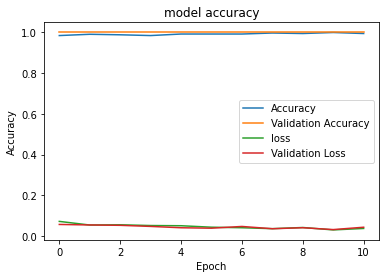

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [0]:
model_json_final = model.to_json()
with open("/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/vgg16covid.json", "w") as json_file:
    json_file.write(model_json_final)


Covid


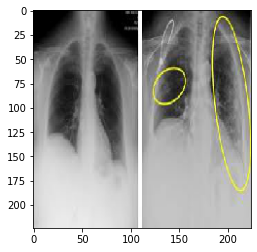

In [16]:
from keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("Covid")
else:
    print('Normal')

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


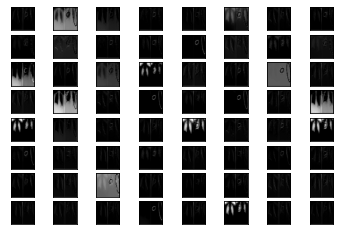

In [22]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img('/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

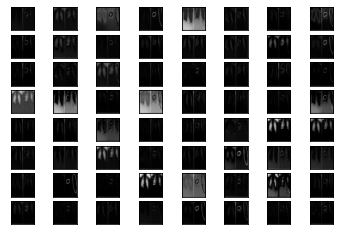

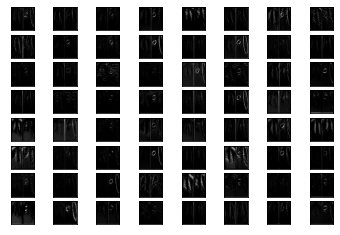

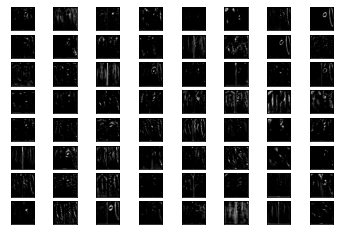

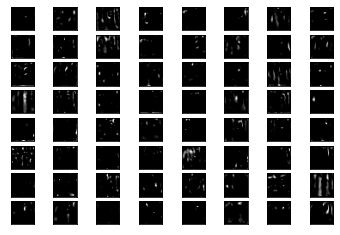

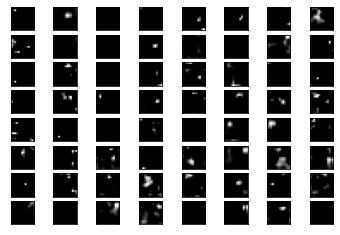

In [23]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('/content/drive/My Drive/3-COVID-19 IMAGE PROCESSING/covid.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()